
# Integrantes:
-Rodrigo Pino

-Cristobal Cortes

-Edgar Ramos

-Christian Garrido


Repositorio: https://github.com/cgarrido2001/PneumoniaMNIST.git

# Acerca de la data

#### El conjunto de datos original consiste en imágenes de rayos X de radiografías de tórax recopiladas de pacientes pediátricos de uno a cinco años del Guangzhou Women and Children's Medical Center en Guangzhou. Inicialmente, el conjunto de datos se divide en dos conjuntos: entrenamiento (train) y prueba (test).

#### Sin embargo, como parte de este proyecto, se realizará una subdivisión adicional del conjunto de entrenamiento para crear un conjunto de validación. Algunos datos del conjunto de entrenamiento se seleccionarán aleatoriamente y se utilizarán como datos de validación para evaluar el rendimiento del modelo durante el entrenamiento.

#### En resumen, el conjunto de datos original comprende imágenes de rayos X de tórax de pacientes pediátricos, divididas en conjuntos de entrenamiento y prueba. Además, como parte del proceso de este proyecto, se creará un conjunto de validación mediante la selección aleatoria de datos del conjunto de entrenamiento.



# Reconocimientos

#### Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

#### License: CC BY 4.0

#### Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


# Importamos librerias

# Importamos la data

In [62]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import numpy as np
import seaborn as sns

In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./chest_xray/train/',
    labels="inferred",
    label_mode="binary",
    class_names=['NORMAL', 'PNEUMONIA'],
    color_mode='rgb',
    image_size=(224, 224),
    shuffle=True,
    seed=10,
    validation_split=0.2,
    subset="training"
)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./chest_xray/train/',
    labels="inferred",
    label_mode="binary",
    class_names=['NORMAL', 'PNEUMONIA'],
    color_mode='rgb',
    image_size=(224, 224),
    shuffle=True,
    seed=10,
    validation_split=0.2,
    subset="validation"
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./chest_xray/test/',
    labels="inferred",
    label_mode="binary",
    class_names=['NORMAL', 'PNEUMONIA'],
    color_mode='rgb',
    image_size=(224, 224),
    shuffle=True,
    seed=10
)



Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


# Visualizamos la data

In [3]:
# Función para mostrar imágenes
def show_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(5):
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if (labels[i] == 0):
              plt.title("NORMAL")
            else:
              plt.title("PNEUMONIA")
            plt.axis("off")
    plt.show()

# Conjunto de entrenamiento

2023-06-02 16:33:35.352683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4186]
	 [[{{node Placeholder/_4}}]]
2023-06-02 16:33:35.352986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4186]
	 [[{{node Placeholder/_4}}]]


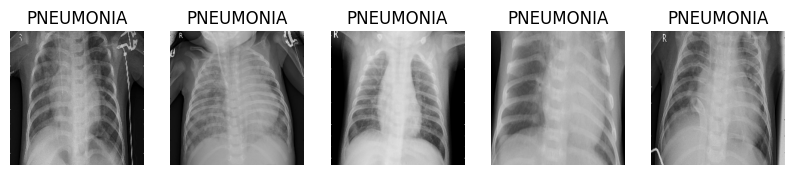

In [4]:
show_images(train_dataset)

# Conjunto de validacion

2023-06-02 16:13:54.635268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1046]
	 [[{{node Placeholder/_4}}]]
2023-06-02 16:13:54.635683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1046]
	 [[{{node Placeholder/_4}}]]


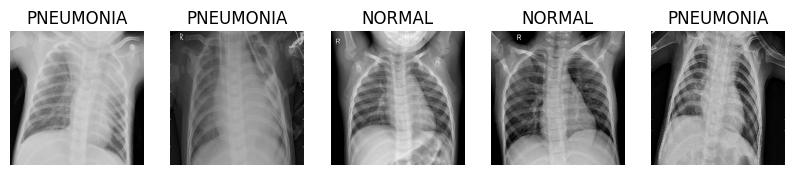

In [67]:
show_images(valid_dataset)

# Conjunto de pruebas

2023-06-02 16:13:59.277402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [624]
	 [[{{node Placeholder/_0}}]]
2023-06-02 16:13:59.277831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [624]
	 [[{{node Placeholder/_4}}]]


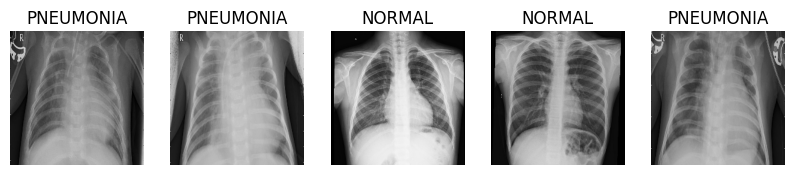

In [68]:
show_images(test_dataset)

# Analizamos los datos

In [5]:
# Contador de registros
normal_count_train = 0
pneumonia_count_train = 0

# Contar registros en el conjunto de entrenamiento
for _, labels in train_dataset:
    normal_count_train += sum(labels.numpy() == 0)
    pneumonia_count_train += sum(labels.numpy() == 1)

# Imprimir los resultados
print("Cantidad de registros en el conjunto de entrenamiento:")
print("Normal: {}".format(normal_count_train))
print("Pneumonía: {}".format(pneumonia_count_train))
print()

# Contador de registros
normal_count_valid = 0
pneumonia_count_valid = 0

# Contar registros en el conjunto de validación
for _, labels in valid_dataset:
    normal_count_valid += sum(labels.numpy() == 0)
    pneumonia_count_valid += sum(labels.numpy() == 1)

# Imprimir los resultados
print("Cantidad de registros en el conjunto de validación:")
print("Normal: {}".format(normal_count_valid))
print("Pneumonía: {}".format(pneumonia_count_valid))
print()

# Contador de registros
normal_count_test = 0
pneumonia_count_test = 0

# Contar registros en el conjunto de prueba
for _, labels in test_dataset:
    normal_count_test += sum(labels.numpy() == 0)
    pneumonia_count_test += sum(labels.numpy() == 1)

# Imprimir los resultados
print("Cantidad de registros en el conjunto de prueba:")
print("Normal: {}".format(normal_count_test))
print("Pneumonía: {}".format(pneumonia_count_test))

2023-06-02 16:33:38.821811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4186]
	 [[{{node Placeholder/_4}}]]
2023-06-02 16:33:38.822495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4186]
	 [[{{node Placeholder/_4}}]]


Cantidad de registros en el conjunto de entrenamiento:
Normal: [1090]
Pneumonía: [3096]



2023-06-02 16:33:44.608622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1046]
	 [[{{node Placeholder/_4}}]]
2023-06-02 16:33:44.608905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1046]
	 [[{{node Placeholder/_0}}]]


Cantidad de registros en el conjunto de validación:
Normal: [259]
Pneumonía: [787]



2023-06-02 16:33:46.117223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [624]
	 [[{{node Placeholder/_0}}]]
2023-06-02 16:33:46.117461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [624]
	 [[{{node Placeholder/_4}}]]


Cantidad de registros en el conjunto de prueba:
Normal: [234]
Pneumonía: [390]


Este análisis muestra la distribución de las etiquetas de clase en cada conjunto de datos. En el conjunto de entrenamiento, hay 1341 imágenes etiquetadas como "Normal" y 3875 imágenes etiquetadas como "Pneumonia". En el conjunto de validación y prueba, las cantidades son mucho menores, con 8 imágenes de cada clase en el conjunto de validación y 234 imágenes "Normales" y 390 imágenes "Pneumonia" en el conjunto de prueba.


 # ________________________________________________________________________________________________________________________________________

# Transfer learning

# VGG16

In [ ]:
# Cargar el modelo preentrenado EfficientNetB0 sin incluir la capa densa superior
base_model = VGG16(weights='imagenet', 
                            include_top=False, 
                            input_shape=(224, 224, 3))

### No se modificaran los pesos y bias del modelo base, por lo que se debera congelar los parametros entrenables

In [54]:
base_model.trainable = False

### Construimos el modelo agregando capas adicionales para la clasificacion binaria

In [17]:
# Construir el modelo final
modelo1 = tf.keras.Sequential()

# Normalización de las imágenes
modelo1.add(BatchNormalization(input_shape=(224, 224, 3)))

# Agregar el modelo base sin incluir la capa densa superior
modelo1.add(base_model)

# Capa de agrupamiento global
modelo1.add(GlobalAveragePooling2D())

# Capa densa con 256 neuronas y función de activación ReLU
modelo1.add(Dense(256, activation='relu'))

# Capa de salida con 1 unidad y función de activación sigmoide
modelo1.add(Dense(1, activation='sigmoid'))

### Compilamos

In [19]:
modelo1.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy", tf.keras.metrics.Recall()])

### Establecer directorio para guardar registros

In [20]:
tb = TensorBoard(log_dir="./logs/VGG16_freezed")

### Entrenamos el modelo

In [ ]:
modelo1.fit(train_dataset, validation_data=valid_dataset, epochs=20, callbacks=[tb])

### Guardamos el modelo

In [ ]:
modelo1.save("./trained_models/VGG16_freezed")

# VGG16 Fine-tuned

In [ ]:
base_model.trainable = False

for layer in base_model.layers[-6:]:
    layer.trainable = True

# Construir el modelo final
modelo1_ft = tf.keras.Sequential()

# Normalización de las imágenes
modelo1_ft.add(BatchNormalization(input_shape=(224, 224, 3)))

# Agregar el modelo base sin incluir la capa densa superior
modelo1_ft.add(base_model)

# Capa de agrupamiento global
modelo1_ft.add(GlobalAveragePooling2D())

# Capa densa con 256 neuronas y función de activación ReLU
modelo1_ft.add(Dense(256, activation='relu'))

# Capa de salida con 1 unidad y función de activación sigmoide
modelo1_ft.add(Dense(1, activation='sigmoid'))



modelo1_ft.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy", tf.keras.metrics.Recall()])


tb = TensorBoard(log_dir="./drive/MyDrive/pneumonia/logs/VGG16_ft")

In [ ]:
modelo1_ft.fit(train_dataset, validation_data=valid_dataset, epochs=20, callbacks=[tb])

In [ ]:
modelo1_ft.save("./drive/MyDrive/pneumonia/trained_models/VGG16_ft")

# Resnet50

In [56]:
# Cargar el modelo preentrenado ResNet50 sin incluir la capa densa superior
base_model_2 = ResNet50(weights='imagenet', 
                            include_top=False, 
                            input_shape=(224, 224, 3))

### No se modificaran los pesos y bias del modelo base, por lo que se debera congelar los parametros entrenables

In [57]:
base_model_2.trainable = False

### Construimos el modelo agregando capas adicionales para la clasificacion binaria

In [ ]:
# Construir el modelo final
modelo2 = tf.keras.Sequential()

# Normalización de las imágenes
modelo2.add(BatchNormalization(input_shape=(224, 224, 3)))

# Agregar el modelo base sin incluir la capa densa superior
modelo2.add(base_model_2)

# Capa de agrupamiento global
modelo2.add(GlobalAveragePooling2D())

# Capa densa con 256 neuronas y función de activación ReLU
modelo2.add(Dense(256, activation='relu'))

# Capa de salida con 1 unidad y función de activación sigmoide
modelo2.add(Dense(1, activation='sigmoid'))

### Compilamos

In [ ]:
modelo2.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy", tf.keras.metrics.Recall()])

### Establecer directorio para guardar registros

In [ ]:
tb = TensorBoard(log_dir="./logs/Resnet50_freezed")

### Entrenamos el modelo

In [ ]:
modelo2.fit(train_dataset, validation_data=valid_dataset, epochs=20, callbacks=[tb])

# Guardamos el modelo

In [ ]:
modelo2.save("./trained_models/Resnet50_freezed")

# ResNet50 Fine-tuned

In [ ]:
base_model_2.trainable = False

for layer in base_model_2.layers[-10:]:
    layer.trainable = True

# Construir el modelo final
modelo2_ft = tf.keras.Sequential()

# Normalización de las imágenes
modelo2_ft.add(BatchNormalization(input_shape=(224, 224, 3)))

# Agregar el modelo base sin incluir la capa densa superior
modelo2_ft.add(base_model)

# Capa de agrupamiento global
modelo2_ft.add(GlobalAveragePooling2D())

# Capa densa con 256 neuronas y función de activación ReLU
modelo2_ft.add(Dense(256, activation='relu'))

# Capa de salida con 1 unidad y función de activación sigmoide
modelo2_ft.add(Dense(1, activation='sigmoid'))



modelo2_ft.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy", tf.keras.metrics.Recall()])


tb = TensorBoard(log_dir="./drive/MyDrive/pneumonia/logs/ResNet50_ft")

In [ ]:
modelo2_ft.fit(train_dataset, validation_data=valid_dataset, epochs=20, callbacks=[tb])

In [ ]:
modelo2_ft.save("./drive/MyDrive/pneumonia/trained_models/ResNet50_ft") 

# Una vez terminado el proceso de almacenar de los modelos. Se pueden cargar de la siguiente manera.

In [5]:
Resnet50_freezed = load_model("./trained_models/Resnet50_freezed/")
Resnet50_ft = load_model("./trained_models/ResNet50_ft/")
VGG16_freezed = load_model("./trained_models/VGG16_freezed/")
VGG16_ft = load_model("./trained_models/VGG16_ft/")

# Obtenemos las etiquetas de validacion

In [19]:
etiquetas_verdaderas_validacion = []
for imagenes, etiquetas in valid_dataset:
    etiquetas_verdaderas_validacion.extend(etiquetas.numpy())

etiquetas_verdaderas_validacion = np.array(etiquetas_verdaderas_validacion)
print(f"En el set de validacion se obtuvieron {len(etiquetas_verdaderas_validacion)} etiquetas")

En el set de validacion se obtuvieron 1046 etiquetas


# Obtenemos las etiquetas de prueba

In [20]:
etiquetas_verdaderas_test = []
for imagenes, etiquetas in test_dataset:
    etiquetas_verdaderas_test.extend(etiquetas.numpy())

etiquetas_verdaderas_test = np.array(etiquetas_verdaderas_test)
print(f"En el set de test se obtuvieron {len(etiquetas_verdaderas_test)} etiquetas")

En el set de test se obtuvieron 624 etiquetas


# Obtenemos las matrices de confusion de cada modelo con el set de validacion

In [39]:
y_predict_resnet50_freezed = Resnet50_freezed.predict(valid_dataset)  
y_predict_resnet50_ft = Resnet50_ft.predict(valid_dataset)
y_predict_VGG16_freezed = VGG16_freezed.predict(valid_dataset)
y_predict_VGG16_ft = VGG16_ft.predict(valid_dataset)

33/33 [==============================] - 139s 4s/step


In [52]:
print(y_predict_resnet50_freezed[0])
print(y_predict_resnet50_ft[0])
print(y_predict_VGG16_freezed[0])
print(y_predict_VGG16_ft[0])

[0.99992824]
[0.9999602]
[0.99999905]
[2.109968e-05]


# Aproximamos las probabilidades a 0 o 1

In [53]:
umbral = 0.5
y_predict_resnet50_freezed_aprox = np.where(y_predict_resnet50_freezed > umbral, 1, 0)
y_predict_resnet50_ft_aprox = np.where(y_predict_resnet50_ft > umbral, 1, 0)
y_predict_VGG16_freezed_aprox = np.where(y_predict_VGG16_freezed > umbral, 1, 0)
y_predict_VGG16_ft_aprox = np.where(y_predict_VGG16_ft > umbral, 1, 0)

In [54]:
print(y_predict_resnet50_freezed_aprox[0])
print(y_predict_resnet50_ft_aprox[0])
print(y_predict_VGG16_freezed_aprox[0])
print(y_predict_VGG16_ft_aprox[0])

[1]
[1]
[1]
[0]


# Ahora calculamos las matrices de confusion

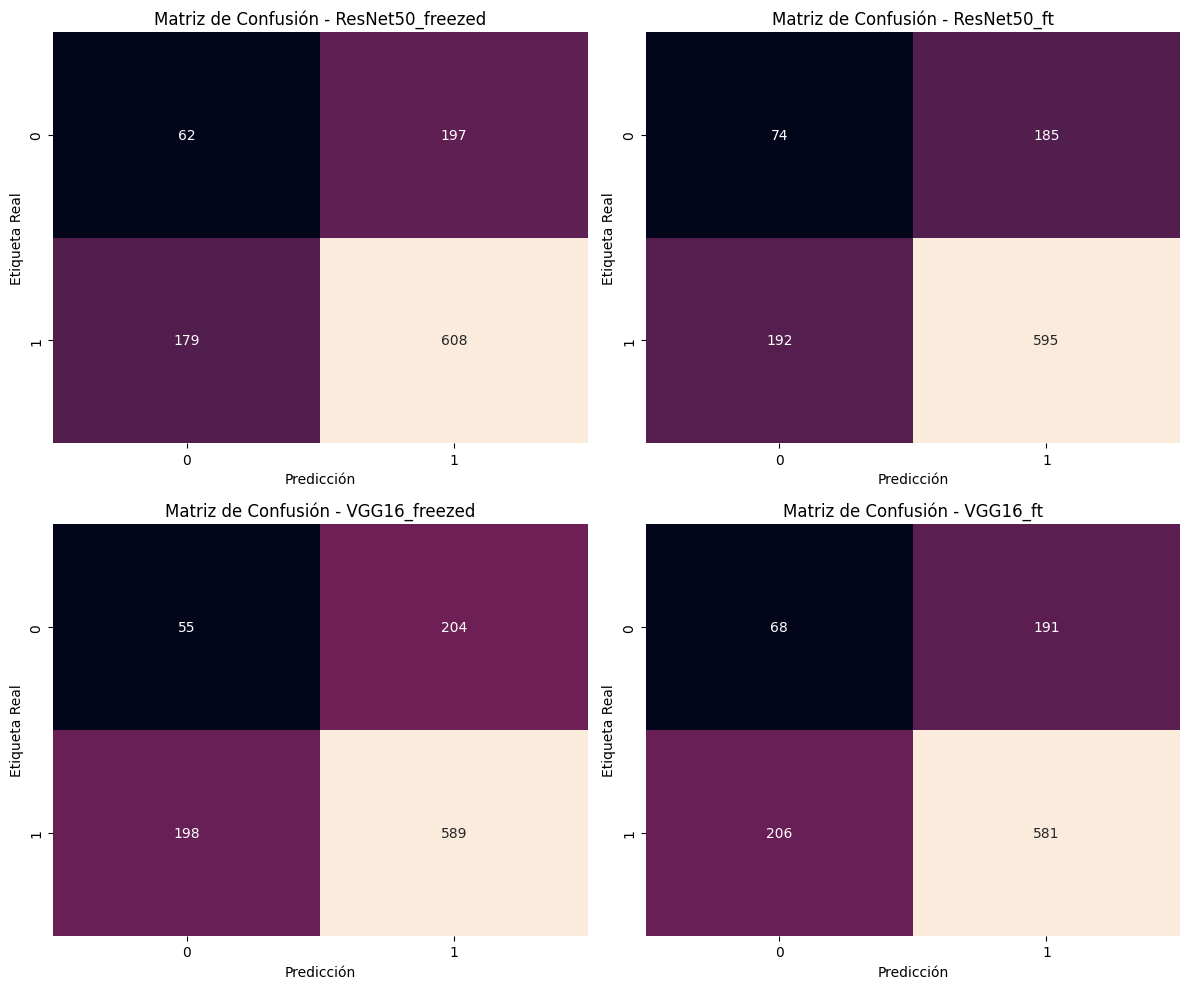

In [95]:
# Matriz de confusión para ResNet50_freezed
matriz_confusion_resnet50_freezed = confusion_matrix(etiquetas_verdaderas_validacion, y_predict_resnet50_freezed_aprox)

# Matriz de confusión para ResNet50_ft
matriz_confusion_resnet50_ft = confusion_matrix(etiquetas_verdaderas_validacion, y_predict_resnet50_ft_aprox)

# Matriz de confusión para VGG16_freezed
matriz_confusion_vgg16_freezed = confusion_matrix(etiquetas_verdaderas_validacion, y_predict_VGG16_freezed_aprox)

# Matriz de confusión para VGG16_ft
matriz_confusion_vgg16_ft = confusion_matrix(etiquetas_verdaderas_validacion, y_predict_VGG16_ft_aprox)

# Crear una lista de matrices de confusión y una lista de nombres de modelos
matrices_confusion = [matriz_confusion_resnet50_freezed, matriz_confusion_resnet50_ft,
                      matriz_confusion_vgg16_freezed, matriz_confusion_vgg16_ft]
nombres_modelos = ['ResNet50_freezed', 'ResNet50_ft', 'VGG16_freezed', 'VGG16_ft']

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 10))

# Generar subplots para cada matriz de confusión
for i in range(len(matrices_confusion)):
    plt.subplot(2, 2, i+1)
    
    # Utilizar seaborn para visualizar la matriz de confusión como un mapa de calor
    sns.heatmap(matrices_confusion[i], annot=True, fmt='d', cbar=False)
    
    # Configurar los nombres de los ejes y el título
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión - ' + nombres_modelos[i])

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


# Reportes

In [87]:
from sklearn.metrics import classification_report

target_names = ['Normal', 'Pneumonia']

print("\nReporte de Clasificación: RESNET50_FREEZED")
print(classification_report(etiquetas_verdaderas_validacion, y_predict_resnet50_freezed_aprox, target_names=target_names))


Reporte de Clasificación: RESNET50_FREEZED
              precision    recall  f1-score   support

      Normal       0.26      0.24      0.25       259
   Pneumonia       0.76      0.77      0.76       787

    accuracy                           0.64      1046
   macro avg       0.51      0.51      0.51      1046
weighted avg       0.63      0.64      0.64      1046



In [88]:
print("\nReporte de Clasificación RESNET50 FT:")
print(classification_report(etiquetas_verdaderas_validacion, y_predict_resnet50_ft_aprox, target_names=target_names))



Reporte de Clasificación RESNET50 FT:
              precision    recall  f1-score   support

      Normal       0.28      0.29      0.28       259
   Pneumonia       0.76      0.76      0.76       787

    accuracy                           0.64      1046
   macro avg       0.52      0.52      0.52      1046
weighted avg       0.64      0.64      0.64      1046



In [89]:
print("\nReporte de Clasificación VGG16 FREEZED:")
print(classification_report(etiquetas_verdaderas_validacion, y_predict_VGG16_freezed_aprox, target_names=target_names))


Reporte de Clasificación VGG16 FREEZED:
              precision    recall  f1-score   support

      Normal       0.22      0.21      0.21       259
   Pneumonia       0.74      0.75      0.75       787

    accuracy                           0.62      1046
   macro avg       0.48      0.48      0.48      1046
weighted avg       0.61      0.62      0.61      1046



In [90]:
print("\nReporte de Clasificación VGG16 FT:")
print(classification_report(etiquetas_verdaderas_validacion, y_predict_VGG16_ft_aprox, target_names=target_names))


Reporte de Clasificación VGG16 FT:
              precision    recall  f1-score   support

      Normal       0.25      0.26      0.26       259
   Pneumonia       0.75      0.74      0.75       787

    accuracy                           0.62      1046
   macro avg       0.50      0.50      0.50      1046
weighted avg       0.63      0.62      0.62      1046



# Observando el reporte de las matrices de confusión para cada modelo, podemos realizar los siguientes análisis:

* ResNet50_ft: Tiene una precisión promedio del 76% y un recall promedio del 76% para la clase "Pneumonia", lo cual indica un buen equilibrio en la capacidad de identificar casos positivos de neumonía. Aunque su rendimiento en la clase "Normal" es inferior, presenta el mejor desempeño en comparación con los otros modelos evaluados.

* VGG16_freezed: Aunque tiene una precisión promedio del 74% y un recall promedio del 75% para la clase "Pneumonia", su desempeño en la clase "Normal" es más bajo, con una precisión promedio del 22% y un recall promedio del 21%. Aun así, se posiciona en segundo lugar debido a su rendimiento en la detección de casos positivos de neumonía.

* VGG16_ft: Tiene una precisión promedio del 75% y un recall promedio del 74% para la clase "Pneumonia", lo cual es similar al desempeño de VGG16_freezed. Sin embargo, su rendimiento en la clase "Normal" es ligeramente mejor, con una precisión promedio del 25% y un recall promedio del 26%. Esto lo coloca en el tercer lugar del ranking.

* ResNet50_freezed: Tiene el peor desempeño en comparación con los otros modelos evaluados. Su precisión promedio del 26% y recall promedio del 24% para la clase "Pneumonia" indican dificultades en la detección de casos positivos de neumonía. Además, su rendimiento en la clase "Normal" es bajo, con una precisión promedio del 26% y un recall promedio del 24%.

# Tambien debemos observar los graficos de rendimiento de los modelos con el set de validacion, mediante TensorBoard

In [66]:
tb = TensorBoard(log_dir="./logs")
!tensorboard --logdir=./logs

2023-06-06 16:54:33.957047: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-06 16:54:34.791178: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.3 at http://localhost:6006/ (Press CTRL+C to quit)
^C


# VGG16


# Accuracy vs epochs

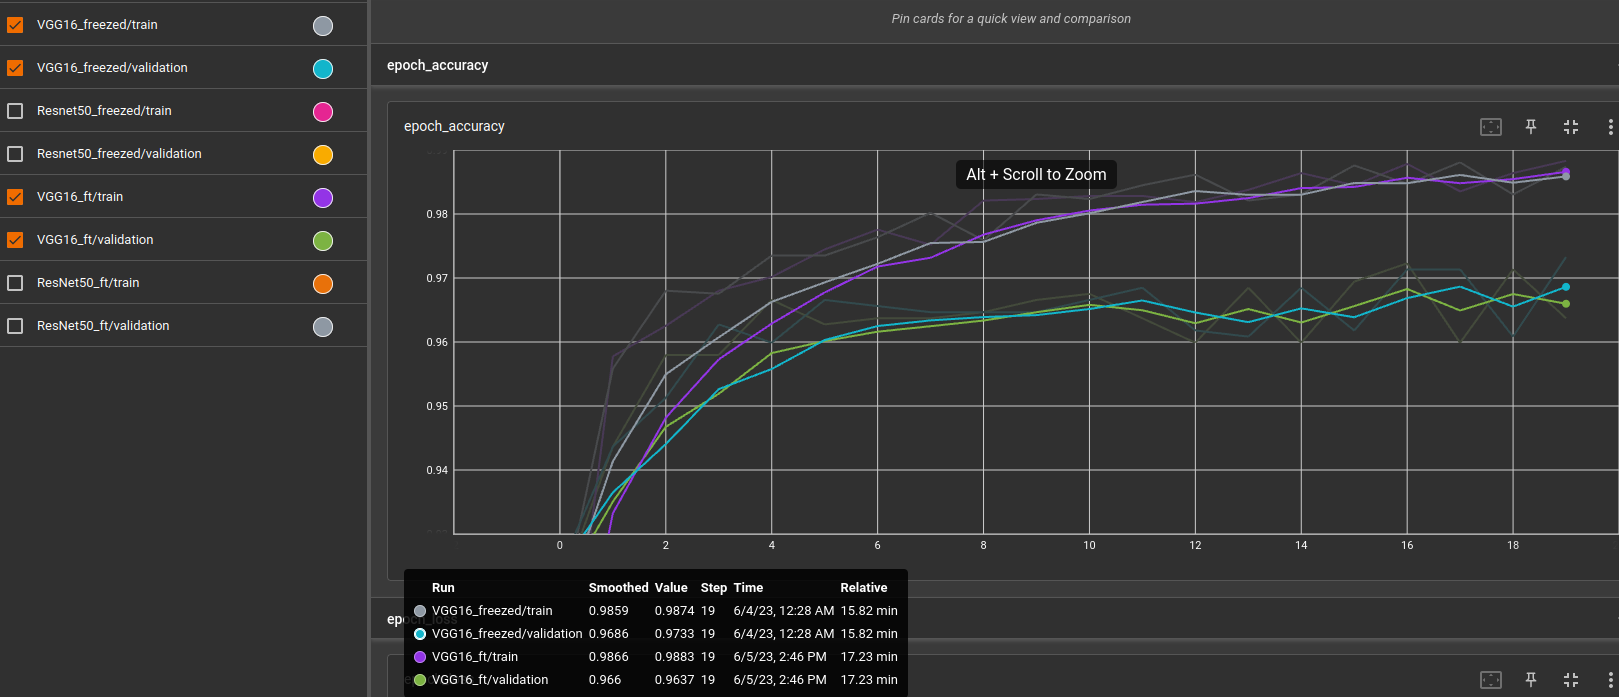


# Loss vs epochs
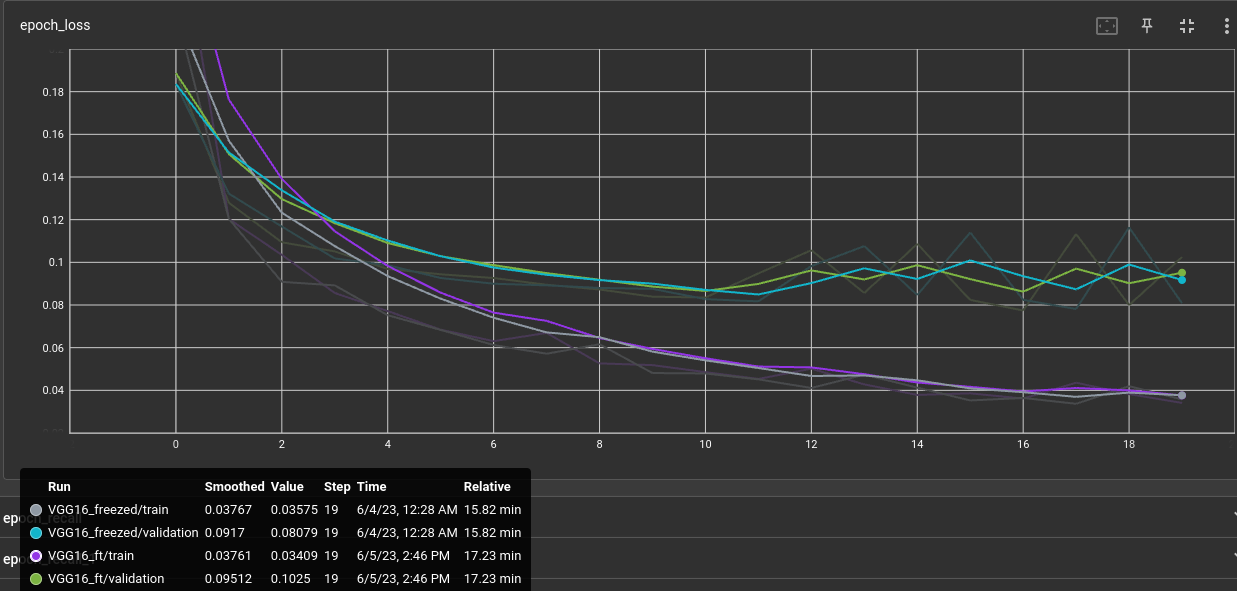

# Recall vs epochs

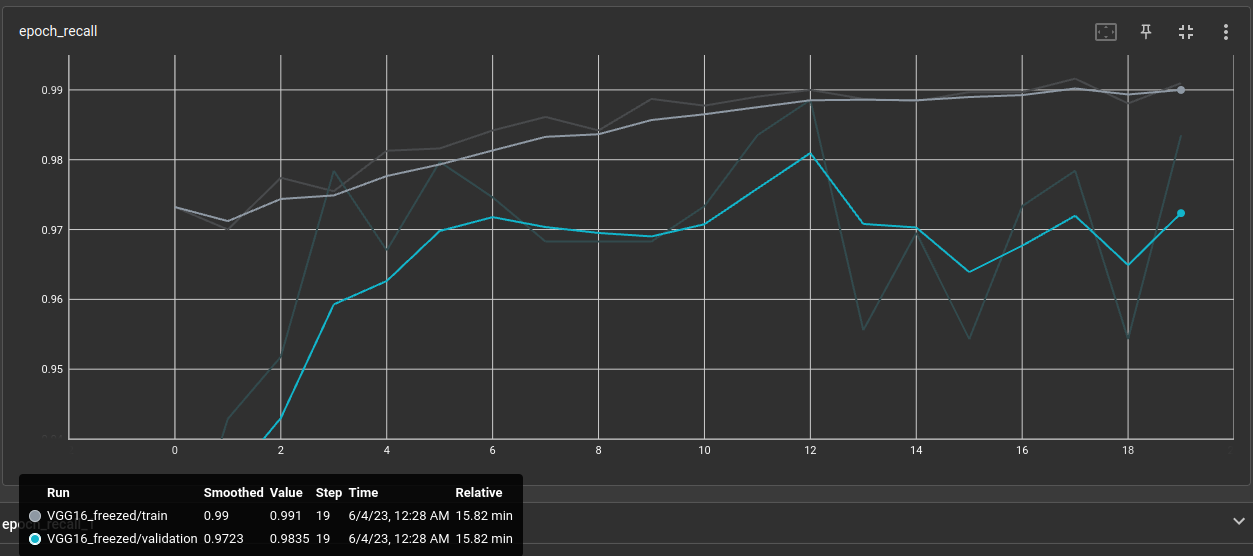

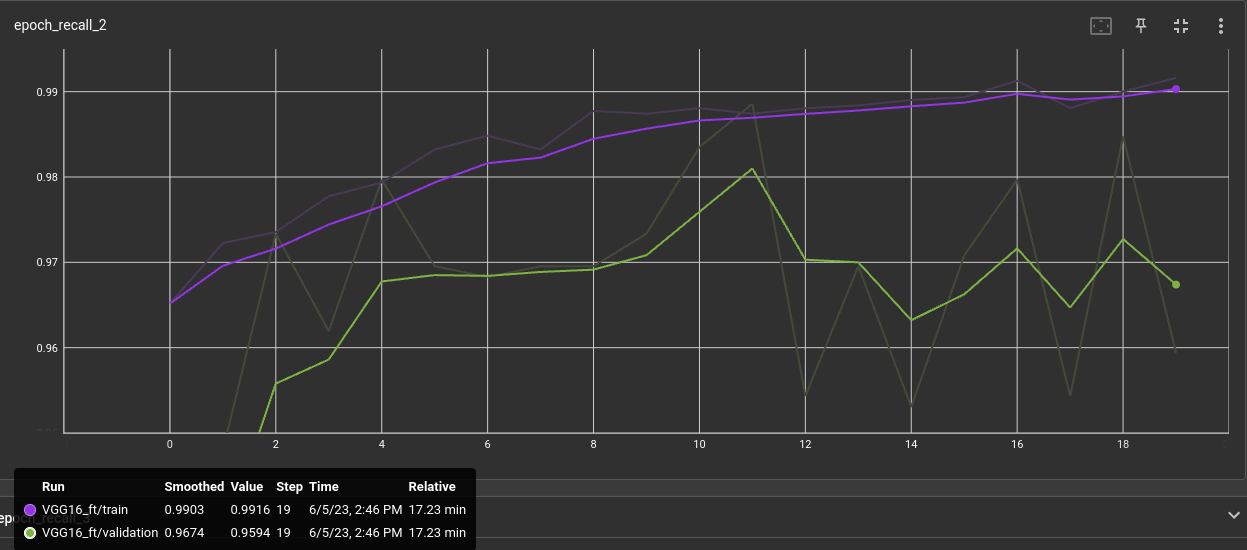

# ___________________________________________________________________________________________________________________________________________________________________________________________

# ResNet50


# Accuracy vs epochs

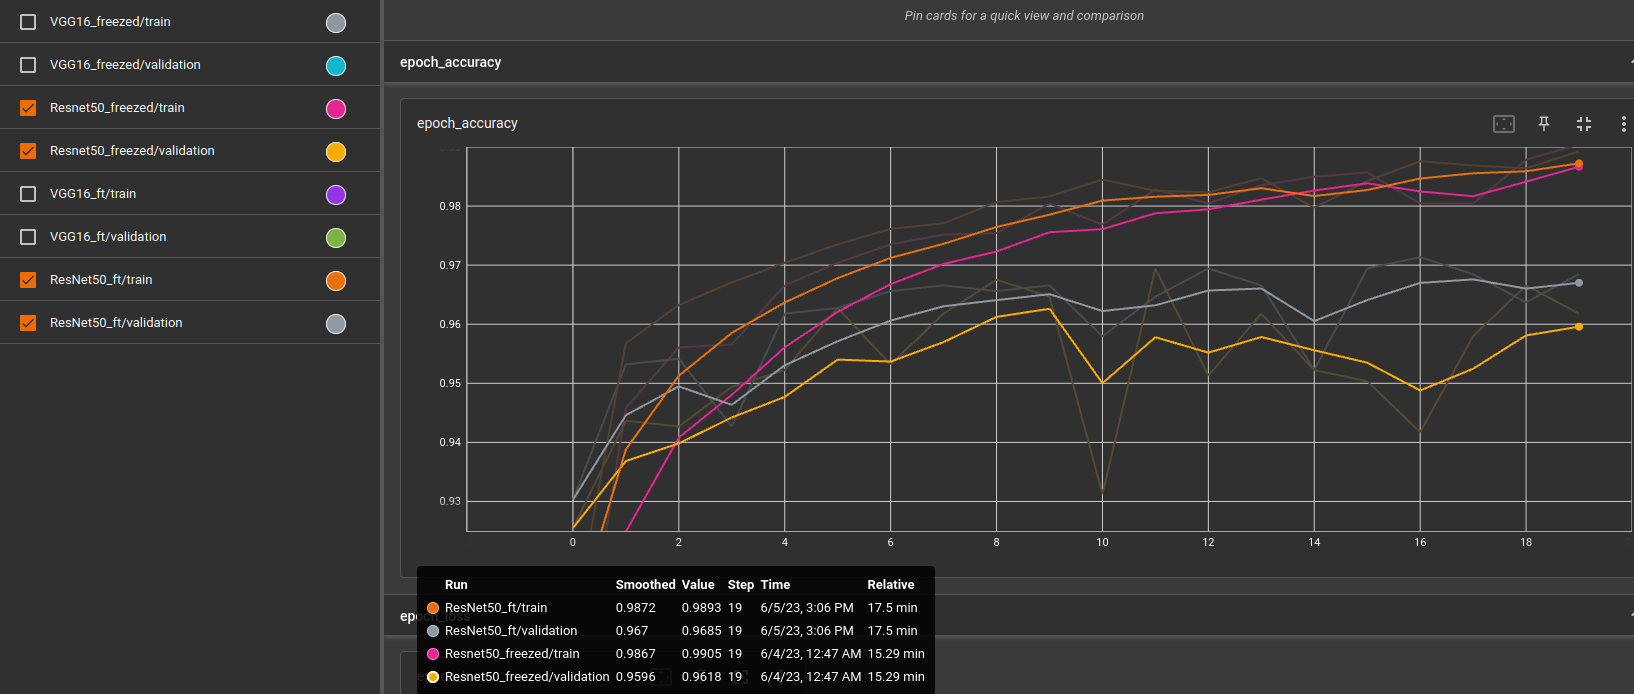



# Loss vs epochs

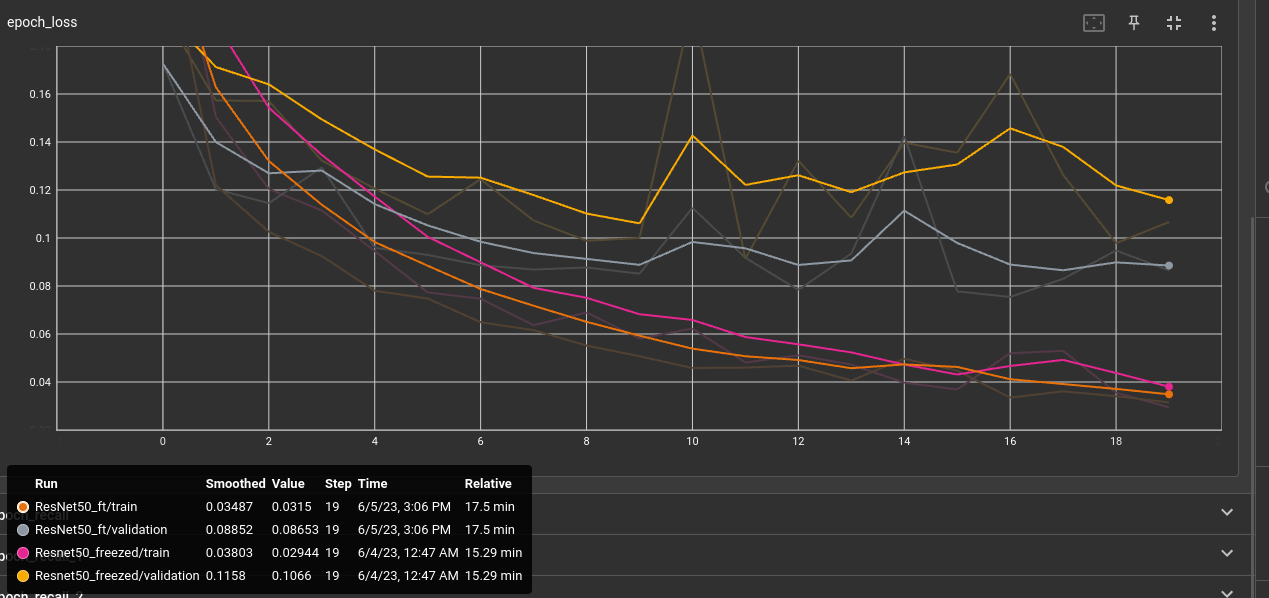


# Recall vs epochs

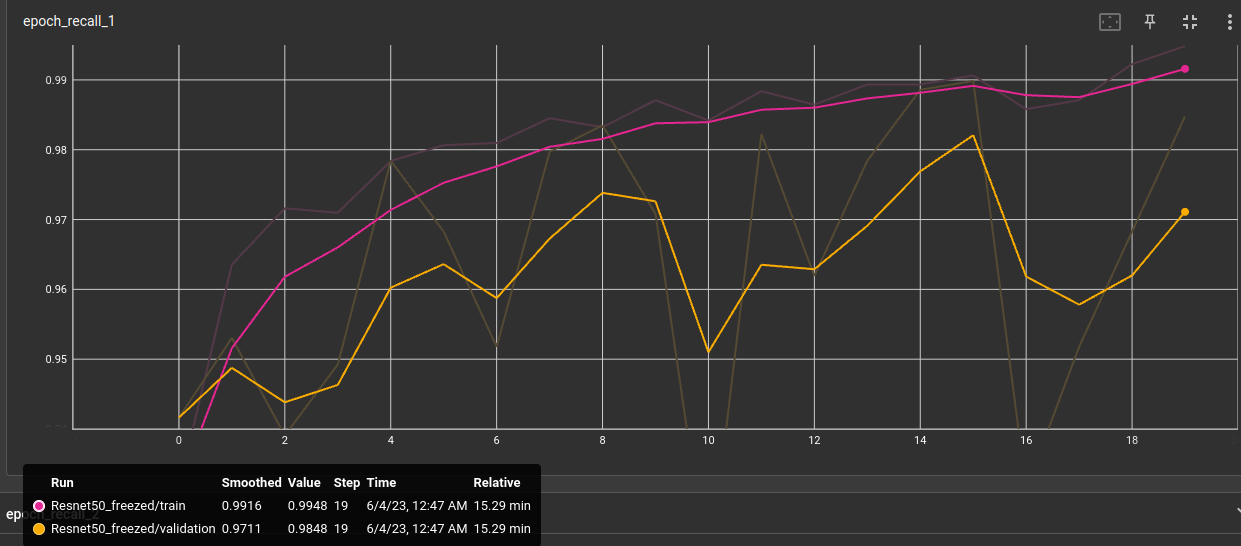


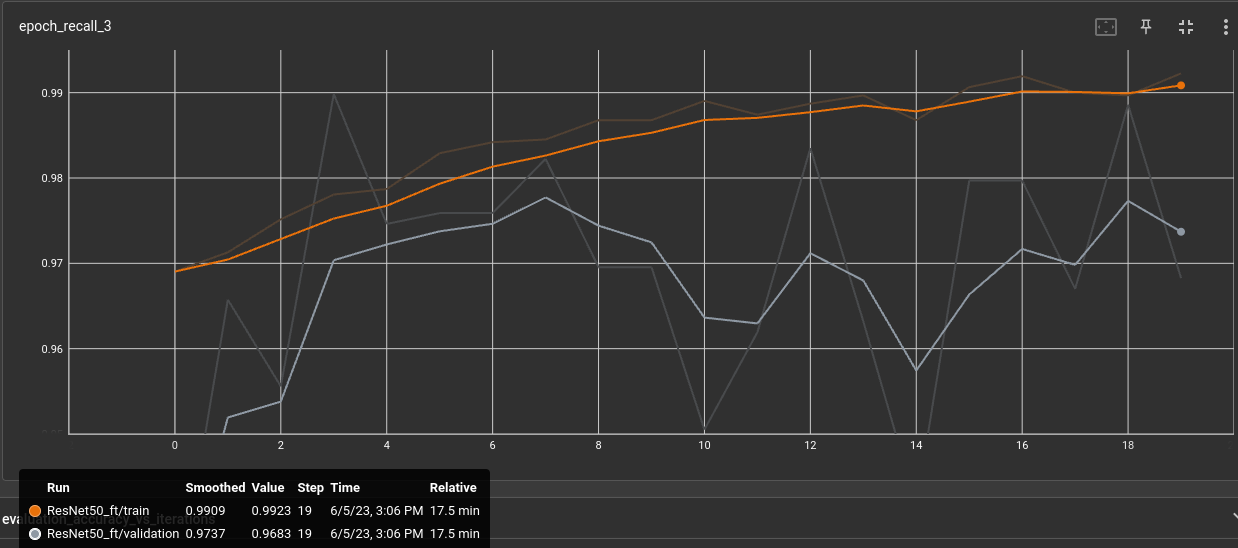

# ________________________________________________________________________________________________________________________________________________________________________

Basándonos en los reportes de clasificación y las métricas proporcionadas, el modelo recomendado para clasificar la neumonía sería el "ResNet50_ft" (ResNet50 fine-tuned). Este modelo presenta una precisión promedio del 76% para la clase "Pneumonia" y un recall promedio del 76% para la misma clase. Además, tiene una precisión promedio del 28% y un recall promedio del 29% para la clase "Normal".

Aunque ninguna de las métricas alcanza valores muy altos, el modelo "ResNet50_ft" muestra el mejor equilibrio entre precisión y recall para ambas clases, lo cual es crucial en el ámbito médico. Además, este modelo tiene una pérdida (loss) más baja en comparación con los otros modelos evaluados.

Es importante tener en cuenta que, dado que el problema está relacionado con la identificación de enfermedades pulmonares, es recomendable contar con una evaluación más exhaustiva, como la validación cruzada y el análisis de más métricas (como la especificidad) y considerar otros factores relevantes para el desempeño del modelo, como la interpretabilidad y la robustez en diferentes escenarios.

# ________________________________________________________________________________________________________________________________________________________________________

# Mejor modelo escogido ResNet50_ft (modelo ResNet50 fine-tuned)


### Evaluamos el mejor modelo con el set de test

In [81]:
y_predict_ResNet50_ft__test = Resnet50_ft.predict(test_dataset)

20/20 [==============================] - 83s 4s/step


In [96]:
print(y_predict_ResNet50_ft__test)

[[9.99187112e-01]
 [9.99952734e-01]
 [9.99994934e-01]
 [9.99998033e-01]
 [9.99987543e-01]
 [9.99984741e-01]
 [9.82099533e-01]
 [9.99393284e-01]
 [9.99979377e-01]
 [9.90226448e-01]
 [9.99909461e-01]
 [3.83823305e-01]
 [9.99999762e-01]
 [9.99997079e-01]
 [9.89985347e-01]
 [9.99995828e-01]
 [9.99999940e-01]
 [6.81381345e-01]
 [3.51865321e-01]
 [9.99975264e-01]
 [9.93115067e-01]
 [7.30328262e-03]
 [7.48778164e-01]
 [9.99998510e-01]
 [9.99608994e-01]
 [9.99984622e-01]
 [4.74616559e-03]
 [3.51467244e-02]
 [9.99998808e-01]
 [9.99992311e-01]
 [9.99999940e-01]
 [9.99351919e-01]
 [9.99478221e-01]
 [9.98825669e-01]
 [9.99999046e-01]
 [9.99464452e-01]
 [1.83101499e-03]
 [1.00000000e+00]
 [9.99971032e-01]
 [9.99999940e-01]
 [2.51909256e-01]
 [1.30402463e-04]
 [1.36714160e-01]
 [9.72683132e-01]
 [9.99997318e-01]
 [9.98891115e-01]
 [9.99988139e-01]
 [9.99998331e-01]
 [9.99705017e-01]
 [9.99867439e-01]
 [9.99088824e-01]
 [9.90162253e-01]
 [9.99994516e-01]
 [9.98228014e-01]
 [9.99986827e-01]
 [6.580626

# Aproximamos los valores a 0 y 1

In [82]:
umbral = 0.5
y_predict_ResNet50_ft__test_aprox = np.where(y_predict_ResNet50_ft__test > umbral, 1, 0)

# Caluculamos la matriz de confusion del mejor modelo con el set de test

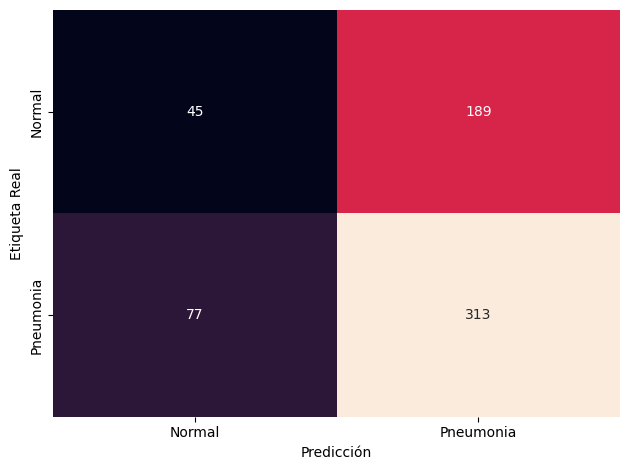

In [91]:
# Matriz de confusión para VGG16_freezed
matriz_confusion_best_model = confusion_matrix(etiquetas_verdad eras_test, y_predict_ResNet50_ft__test_aprox)

# Definir etiquetas de las clases
etiquetas_clases = ['Normal', 'Pneumonia']

# Crear figura y ejes
fig, ax = plt.subplots()

# Crear matriz de colores
sns.heatmap(matriz_confusion_best_model, annot=True, fmt='d', cbar=False, ax=ax)

# Configurar etiquetas de los ejes
ax.set_xlabel('Predicción')
ax.set_ylabel('Etiqueta Real')
ax.set_xticklabels(etiquetas_clases)
ax.set_yticklabels(etiquetas_clases)

# Ajustar espaciado
plt.tight_layout()

# Mostrar gráfico de la matriz de confusión
plt.show()

# Reporte

In [92]:
print("\nReporte de Clasificación ResNet50_ft_test:")
print(classification_report(etiquetas_verdaderas_test, y_predict_ResNet50_ft__test_aprox, target_names=target_names))


Reporte de Clasificación ResNet50_ft_test:
              precision    recall  f1-score   support

      Normal       0.37      0.19      0.25       234
   Pneumonia       0.62      0.80      0.70       390

    accuracy                           0.57       624
   macro avg       0.50      0.50      0.48       624
weighted avg       0.53      0.57      0.53       624



Con el reporte de clasificación para el modelo ResNet50_ft en el conjunto de pruebas (test) se puede analizar lo siguiente:

Para la clase "Normal", el modelo tiene una precisión del 37%, lo que significa que el 37% de las muestras clasificadas como "Normal" son realmente "Normales". El recall, que es la proporción de muestras "Normales" correctamente identificadas, es del 19%. Esto indica que el modelo tiene dificultades para detectar correctamente los casos "Normales" y tiende a clasificarlos erróneamente como casos de neumonía.

Para la clase "Pneumonia", el modelo tiene una precisión del 62%, lo que significa que el 62% de las muestras clasificadas como "Pneumonia" son realmente casos de neumonía. El recall, que es la proporción de muestras de neumonía correctamente identificadas, es del 80%. Esto indica que el modelo tiene un mejor rendimiento en la detección de casos de neumonía y es capaz de identificar correctamente la mayoría de los casos positivos.

La precisión promedio del modelo es del 53% y el recall promedio es del 57%. El f1-score, que es una medida que combina precisión y recall, es del 53%. Estos valores indican un rendimiento generalmente bajo del modelo para la clasificación de ambos casos "Normales" y casos de "Pneumonía".

Para finalizar, el modelo ResNet50_ft muestra un rendimiento deficiente en la clasificación de casos "Normales" de manera precisa y en la detección de neumonía. Sin embargo, tiene una mejor capacidad para identificar correctamente los casos de neumonía en comparación con los casos "Normales". Es importante tener en cuenta que el modelo tiene margen de mejora en términos de precisión y recall para ambas clases.

Algunas opciones para mejorar el rendimiento del modelo a considerar más adelante serian:

- Ajustar Hiperparametros
- Probar diferentes arquitecturas de red
- Utilizar tecnicas de validacion cruzada